# **Generative Adversial Networks**
Generative Adversarial Networks, or GANs for short, are an approach to generative modeling using deep learning methods, such as convolutional neural networks.

Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.


In [ ]:
#Import Libraries
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
from keras import layers, models
import time
import PIL
import os

from IPython import display

currDir = os.getcwd()
path = os.path.join(currDir, 'images_during_training')
os.mkdir(path)

### **Digit-Mnist DataSet**
The MNIST dataset is an acronym that stands for the Modified National Institute of Standards and Technology dataset.

It is a dataset of 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.


In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


Normalizing the images and also adding extra dimension to the data.

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

Defining static variable as hyperparameters

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
noise_dim = 100
EPOCHS=500
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Setting loss function and optimizer for the models

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Image dimensions

In [ ]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

## **Generator Model**
The model takes a noise of shape (1, 100), and create an image of shape 28 x 28 with 1 channel.

Model is of Dense layers with activation LeakyRelu.

In [ ]:
def build_generator():
    noise_shape = (100,) #1D array of size 100 (latent vector / noise)         

    model = models.Sequential()
    model.add(layers.Dense(256, input_shape=noise_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    
    model.add(layers.Dense(np.prod(img_shape), activation='tanh'))
    model.add(layers.Reshape(img_shape))

    model.summary()

    inp = layers.Input(shape=noise_shape)
    op = model(inp)    #Generated image

    return models.Model(inp, op)

#Alpha — α is a hyperparameter which controls the underlying value to which the
#function saturates negatives network inputs.
#Momentum — Speed up the training

In [ ]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                        

tf.Tensor([ 1 28 28  1], shape=(4,), dtype=int32)


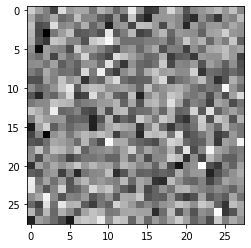

In [ ]:
# Before training of generator network, this is output for a random noise of shape [1, 100]
noise = tf.random.normal((1, 100))
generated_image = generator.predict(noise)
print(tf.squeeze(generated_image.shape))

plt.imshow(tf.squeeze(generated_image), cmap='gray')

## **Discreminator Model**
Given an input image, the Discriminator outputs the likelihood of the image being real.

Binary classification - true or false (we're calling it op_validation)

In [ ]:
def build_discreminator():
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(img_shape)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()

    inp_image = layers.Input(shape=img_shape)
    op_validation = model(inp_image)

    return models.Model(inp_image, op_validation)

In [ ]:
discriminator = build_discreminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-tr

### To save images during training

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm)
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('./images_during_training/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Train step function: The training process done at each epoch of training

In [ ]:
## tf.function allows function to compile
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) # Initialize random noise

    # Running our deep learning model and calculating loss for classification for real and fake images
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: 
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      
    # error while predicting the fake images is used as generator loss to train generator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # error while predicting the fake images as well as real images is used as discriminator loss to train generator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Updating weights and biases for both the models
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Setting up checkpoint directory

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training the model

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    # Training complete dataset in batches
    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

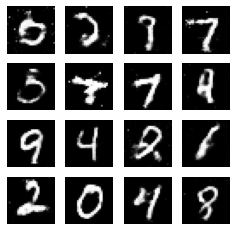

In [ ]:
train(train_dataset, EPOCHS)

Saving the latest model state as checkpoint

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Plotting images produced at final epoch

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    if epoch_no%10==0:
        return PIL.Image.open('./images_during_training/image_at_epoch_{:04d}.png'.format(epoch_no))

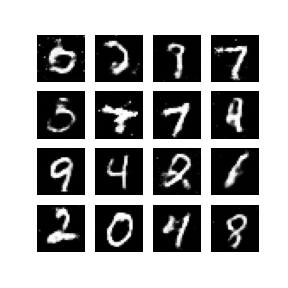

In [ ]:
display_image(EPOCHS)

# Done